In [1]:
%matplotlib inline
from cox import readers
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set()

In [2]:
r = readers.CollectionReader('../src/clip_experiment/agents')

100%|██████████| 240/240 [01:15<00:00,  3.18it/s]


In [3]:
metadata = r.df('metadata')
opt = r.df('optimization')
opt['opt_step'] = opt.index
#nadv = r.df('normalized_advantage')
#nadv['opt_step'] = (nadv.index % 50) * 10
#constraints = r.df('paper_constraints_train')
#constraints_heldout = r.df('paper_constraints_heldout')

In [4]:
games =  ["Walker2d-v2", "Humanoid-v2", "Swimmer-v2", "Hopper-v2",
          "HalfCheetah-v2", "InvertedPendulum-v2", "Reacher-v2", "InvertedDoublePendulum-v2"]
code_level_opts = {
      #'kl_penalty_coeff': [0, 1, 3, 10],
      #'kl_penalty_direction': ['new_to_old', 'old_to_new'],
      'clip_advantages': [3, 5, 1e8],
      #'norm_rewards': ['none', 'returns'],
      #'anneal_lr': [False, True],
      #'value_clipping': [False, True],
      #'initialization': ['xavier', 'orthogonal']
}

NUM_BINS = 20

In [5]:
#metadata['kl_penalty'] = (metadata['kl_penalty_coeff'] > 0)
#code_level_opts = {'kl_penalty': [True, False]}
key_metadata = metadata[['exp_id', 'game'] + list(code_level_opts.keys())]
#constraints = constraints.merge(key_metadata, on='exp_id')
#constraints_heldout = constraints_heldout.merge(key_metadata, on='exp_id')
#nadv = nadv.merge(key_metadata, on='exp_id')
opt = opt.merge(key_metadata, on='exp_id')

# Plot mean rewards

In [ ]:
# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    for i, cl_opt in enumerate(code_level_opts):
        for b in code_level_opts[cl_opt]:
            filt = opt[(opt[cl_opt] == b) & (opt.game == g)]
            sns.lineplot(filt.opt_step, filt.mean_reward,
                         ax=ax.flatten()[j], label=f"{cl_opt}: {b}", legend=False)
        ax.flatten()[j].set_title(g)
        
for a in ax.flatten():
    a.set_ylabel('')
    a.set_xlabel('')
ax[0][0].set_ylabel('Mean Reward')
ax[1][0].set_xlabel('Mean Reward')
for a in ax[1]:
    a.set_xlabel('# Iterations')
    
handles, labels = ax[-1][-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')

plt.show()

# Plot cumulative distribution of max rewards

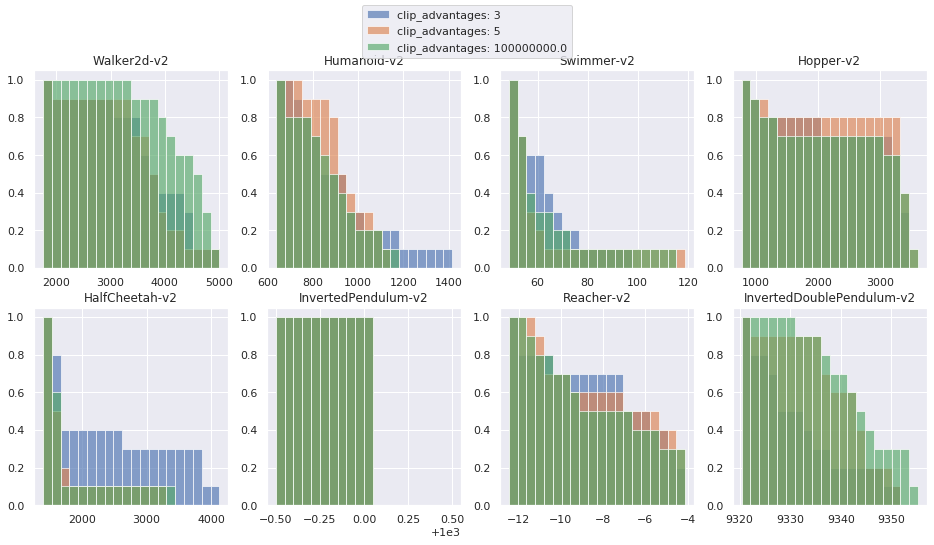

In [6]:
max_rewards = opt.groupby(['exp_id', 'game'] + list(code_level_opts.keys())).max()
max_rewards = max_rewards.reset_index()

# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    # Histogram setup
    _, bin_edges = np.histogram(max_rewards[max_rewards.game == g][
        'mean_reward'].tolist(), NUM_BINS)
    bin_locs = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_ws = (bin_edges[1] - bin_edges[0])
    kwargs = {'width': bin_ws, 'alpha': 0.65}
    
    for i, cl_opt in enumerate(code_level_opts):
        for ib, b in enumerate(code_level_opts[cl_opt]):
            filt = max_rewards[(max_rewards[cl_opt] == b) & (max_rewards.game == g)]
            hist, _ = np.histogram(filt['mean_reward'].tolist(), bin_edges)
            hist = np.flip(np.cumsum(np.flip(hist))) / np.sum(hist)
            ax.flatten()[j].bar(bin_locs, hist, label=f"{cl_opt}: {b}",
                                **kwargs)
        ax.flatten()[j].set_title(g)
handles, labels = ax[-1][-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

# Plot distribution of max rewards

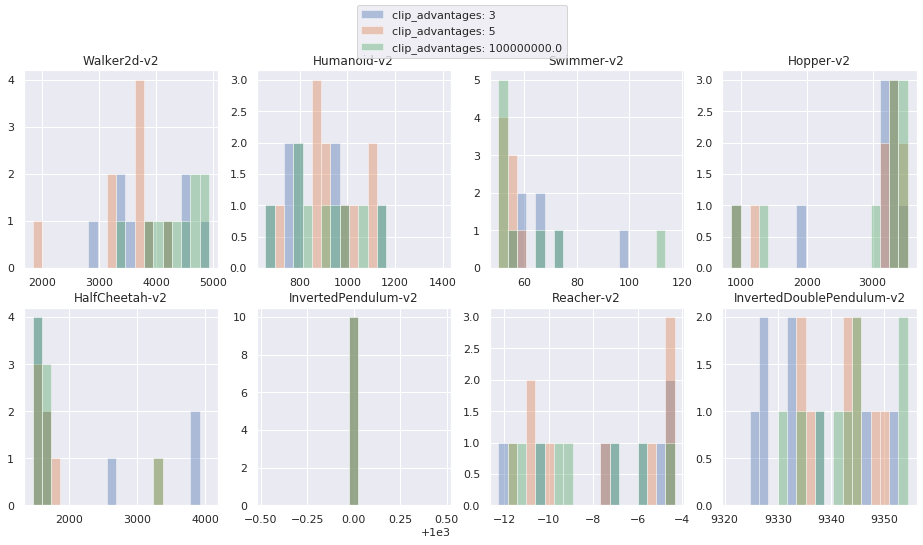

In [7]:
max_rewards = opt.groupby(['exp_id', 'game'] + list(code_level_opts.keys())).max()
max_rewards = max_rewards.reset_index()

# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    # Histogram setup
    _, bin_edges = np.histogram(max_rewards[max_rewards.game == g][
        'mean_reward'].tolist(), NUM_BINS)
    bin_locs = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_ws = (bin_edges[1] - bin_edges[0])
    kwargs = {'width': bin_ws, 'alpha': 0.65}
    
    for i, cl_opt in enumerate(code_level_opts):
        for ib, b in enumerate(code_level_opts[cl_opt]):
            filt = max_rewards[(max_rewards[cl_opt] == b) & (max_rewards.game == g)]
            #hist, _ = np.histogram(filt['mean_reward'].tolist(), bin_edges)
            #hist = np.flip(np.cumsum(np.flip(hist))) / np.sum(hist)
            sns.distplot(filt['mean_reward'].tolist(),
                         bins=bin_locs, label=f"{cl_opt}: {b}", ax=ax.flatten()[j], kde=False)
        ax.flatten()[j].set_title(g)
handles, labels = ax[-1][-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

# Aggregate performance in normalized scores

In [8]:
max_and_min = max_rewards[['game', 'mean_reward']].groupby('game').max().rename(
    columns={'mean_reward': 'max_max_reward'})
max_and_min['min_max_reward'] = max_rewards[['game', 'mean_reward']].groupby('game').min()

In [9]:
ks = ['game'] + list(code_level_opts.keys())
grouped = max_rewards[ks + ['mean_reward']].groupby(ks).mean().reset_index().set_index(ks)
grouped = grouped.rename(columns={'mean_reward': 'mean_max_reward'})
grouped['stddev'] = max_rewards[ks + ['mean_reward']].groupby(ks).var().reset_index().set_index(ks).apply(np.sqrt)
grouped = grouped.reset_index()
grouped = grouped.reset_index().merge(max_and_min, on='game')
grouped = grouped.set_index(ks)
grouped['normalized_score'] = (grouped['mean_max_reward'] - grouped['min_max_reward']) / (
    grouped['max_max_reward'] - grouped['min_max_reward'])
grouped['normalized_stddev'] = grouped['stddev'] / (
    grouped['max_max_reward'] - grouped['min_max_reward'])
grouped = grouped.dropna()
grouped

index  mean_max_reward  \
game                      clip_advantages                           
HalfCheetah-v2            3.0                  0      2377.716421   
                          5.0                  1      1720.924263   
                          100000000.0          2      1723.361572   
Hopper-v2                 3.0                  3      2673.857848   
                          5.0                  4      2887.946620   
                          100000000.0          5      2632.096870   
Humanoid-v2               3.0                  6       922.038503   
                          5.0                  7       934.630624   
                          100000000.0          8       877.120450   
InvertedDoublePendulum-v2 3.0                  9      9332.237727   
                          5.0                 10      9340.090317   
                          100000000.0         11      9343.793102   
Reacher-v2                3.0                 15        -7.365298   
                          5.0                 16        -7.362289   
                          100000000.0         17        -7.768829   
Swimmer-v2                3.0                 18        62.753474   
                          5.0                 19        60.027600   
                          100000000.0         20        61.644826   
Walker2d-v2               3.0                 21      3697.892670   
                          5.0                 22      3624.030907   
                          100000000.0         23      4339.680013   

                                                stddev  max_max_reward  \
game                      clip_advantages                                
HalfCheetah-v2            3.0              1122.779849     4121.784062   
                          5.0               562.387366     4121.784062   
                          100000000.0       574.180061     4121.784062   
Hopper-v2                 3.0              1037.658770     3605.286073   
                          5.0               989.589756     3605.286073   
                          100000000.0      1125.209998     3605.286073   
Humanoid-v2               3.0               224.504344     1416.027813   
                          5.0               118.479256     1416.027813   
                          100000000.0       165.817540     1416.027813   
InvertedDoublePendulum-v2 3.0                10.543082     9355.257532   
                          5.0                 8.779426     9355.257532   
                          100000000.0         8.368770     9355.257532   
Reacher-v2                3.0                 3.200961       -4.114490   
                          5.0                 3.131640       -4.114490   
                          100000000.0         3.039294       -4.114490   
Swimmer-v2                3.0                14.724619      118.959728   
                          5.0                20.958707      118.959728   
                          100000000.0        19.405540      118.959728   
Walker2d-v2               3.0               903.744531     5001.936742   
                          5.0               803.802460     5001.936742   
                          100000000.0       506.749145     5001.936742   

                                           min_max_reward  normalized_score  \
game                      clip_advantages                                     
HalfCheetah-v2            3.0                 1402.108302          0.358722   
                          5.0                 1402.108302          0.117226   
                          100000000.0         1402.108302          0.118122   
Hopper-v2                 3.0                  776.283085          0.670757   
                          5.0                  776.283085          0.746434   
                          100000000.0          776.283085          0.655996   
Humanoid-v2               3.0                  636.135856          0.366593   
                          5.0            

In [10]:
ks = ['game'] + list(code_level_opts.keys())
tmp = max_rewards[ks + ['mean_reward']].merge(max_and_min, on='game')
tmp['normalized_score'] = (tmp['mean_reward'] - tmp['min_max_reward']) / (
    tmp['max_max_reward'] - tmp['min_max_reward'])
normalized_score = tmp[['game', 'clip_advantages', 'normalized_score']]
normalized_score['game'] = normalized_score['game'].apply(lambda s: s.strip('-v2'))

/home/eecs/chloehsu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


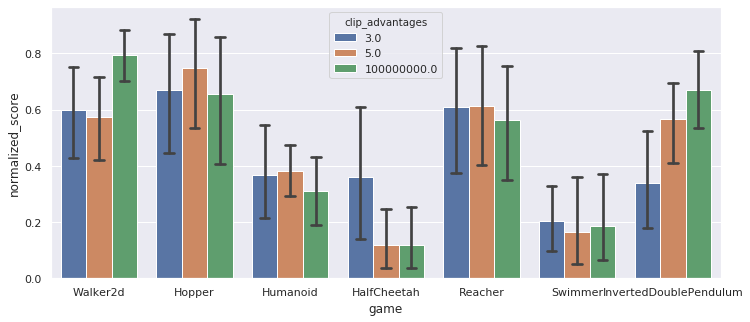

In [11]:
plt.figure(figsize=(12, 5))
sns.barplot(x="game", y="normalized_score", hue="clip_advantages",
            data=normalized_score.dropna().reset_index(), capsize=.1)